# Part3: Emotions & Images in Tweets - Training the model
> The goal of this project is to mark detection from images posted along with tweets.

- toc: true 
- badges: true
- comments: true
- categories: [jupyter]
- image: images/resnet50.png

## Approach
Using AlexNet


## Beyond the Text 
Beside the text, Twitter messages often include images, emojis or other special characters.
One approach to understand the overall sentiments from tweets is to work with each layer of information separately and then combining the analysis to reach a result that reflects all layers of the information.
This section will look at images separate from the text. Unpacking a way of analyzing images. 

## How to understand images?
We often understand a complex set of meaning from an image through a quick glance but what does it take for an automated system to understand the interplay of meaning in an image. There are multiple approaches in understanding an image. For instance, an image could be segregating into objects through image segmentation and using further meaning driven analysis a meaning of the image can be formed. 
But a holistic approach could prove beneficial too. Considering the multitude and complexities that are involved in making sense of images. The first approach here is use a pre-trained resnet model to identify emotions through images. 
The idea is that we could train a Machine Learning model with a set of images. After the initial training stage, the model should be able to identify the meaning of any new image that we get from tweets for instance.


## Project Goals
In this project, I’m looking to identify the overall reaction around a certain topic. One approach would be to identify tweets based on their underlying sentiment, such as anger, joy, sadness, etc. The first step is to find a dataset which includes images with their corresponding labels. This dataset can be used to train the initial model. 
Looking for such a dataset, I found [Emotion6] dataset from [Cornel University AMP lab] (http://chenlab.ece.cornell.edu/downloads.html).  Emotion6 is a collection of 1980 images and is divided into six categories of anger, disgust, fear, joy sadness, neutral .

## Citations
[1] Kuan-Chuan Peng, Amir Sadovnik, Andrew Gallagher, and Tsuhan Chen. "A Mixed Bag of Emotions: Model, Predict, and Transfer Emotion Distributions.", Computer Vision and Pattern Recognition (CVPR), 2015.

In [69]:
import torch
import torch.nn as nn
from torchvision.transforms import transforms
import numpy as np
from torch.autograd import Variable
from torchvision.models import squeezenet1_1
import torch.functional as F
from io import open
import os
from PIL import Image
import pathlib
import glob

from torchvision import models

In [70]:
train_path='Data/Emotion6/images/emot_train'
pred_path='Data/Emotion6/images/emot_pred'

In [71]:
#categories
root=pathlib.Path(train_path)
classes=sorted([j.name.split('/')[-1] for j in root.iterdir()])

In [5]:
#CNN Network


class ConvNet(nn.Module):
    def __init__(self,num_classes=6):
        super(ConvNet,self).__init__()
        
        #Output size after convolution filter
        #((w-f+2P)/s) +1
        
        #Input shape= (256,3,150,150)
        
        self.conv1=nn.Conv2d(in_channels=3,out_channels=12,kernel_size=3,stride=1,padding=1)
        #Shape= (256,12,150,150)
        self.bn1=nn.BatchNorm2d(num_features=12)
        #Shape= (256,12,150,150)
        self.relu1=nn.ReLU()
        #Shape= (256,12,150,150)
        
        self.pool=nn.MaxPool2d(kernel_size=2)
        #Reduce the image size be factor 2
        #Shape= (256,12,75,75)
        
        
        self.conv2=nn.Conv2d(in_channels=12,out_channels=20,kernel_size=3,stride=1,padding=1)
        #Shape= (256,20,75,75)
        self.relu2=nn.ReLU()
        #Shape= (256,20,75,75)
        
        
        
        self.conv3=nn.Conv2d(in_channels=20,out_channels=32,kernel_size=3,stride=1,padding=1)
        #Shape= (256,32,75,75)
        self.bn3=nn.BatchNorm2d(num_features=32)
        #Shape= (256,32,75,75)
        self.relu3=nn.ReLU()
        #Shape= (256,32,75,75)
        
        
        self.fc=nn.Linear(in_features=75 * 75 * 32,out_features=num_classes)
        
        
        
        #Feed forwad function
        
    def forward(self,input):
        output=self.conv1(input)
        output=self.bn1(output)
        output=self.relu1(output)
            
        output=self.pool(output)
            
        output=self.conv2(output)
        output=self.relu2(output)
            
        output=self.conv3(output)
        output=self.bn3(output)
        output=self.relu3(output)
            
            
            #Above output will be in matrix form, with shape (256,32,75,75)
            
        output=output.view(-1,32*75*75)
            
            
        output=self.fc(output)
            
        return output

In [6]:
class AlexNet(nn.Module):

    def __init__(self, num_classes):
        super(AlexNet, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=11, stride=4, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(64, 192, kernel_size=5, padding=2),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
            nn.Conv2d(192, 384, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(384, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        self.avgpool = nn.AdaptiveAvgPool2d((6, 6))
        self.classifier = nn.Sequential(
            nn.Dropout(0.5),
            nn.Linear(256 * 6 * 6, 4096),
            nn.ReLU(inplace=True),
            nn.Dropout(0.5),
            nn.Linear(4096, 4096),
            nn.ReLU(inplace=True),
            nn.Linear(4096, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), 256 * 6 * 6)
        logits = self.classifier(x)
#         probas = F.softmax(logits, dim=1)
        return logits

In [72]:
# checkpoint=torch.load('best_checkpoint_CNN1.model')

checkpoint=torch.load('best_checkpoint.model')
# model = models.vgg16(pretrained=False)
# model=ConvNet(num_classes=6)
# model=AlexNet(num_classes=6)

model = models.resnet18()

model.load_state_dict(checkpoint)
model.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [85]:
#Transforms
transformer=transforms.Compose([
    transforms.Resize((150,150)),
    transforms.ToTensor(),  #0-255 to 0-1, numpy to tensors
    transforms.Normalize([0.5,0.5,0.5], # 0-1 to [-1,1] , formula (x-mean)/std
                        [0.5,0.5,0.5])
])


images_path=glob.glob(pred_path+'/*.jpg')


In [86]:
#prediction function
def prediction(img_path,transformer):
    
    image=Image.open(img_path)
    
    image_tensor=transformer(image).float()
    
    
    image_tensor=image_tensor.unsqueeze_(0)
    
    if torch.cuda.is_available():
        image_tensor.cuda()
        
    input=Variable(image_tensor)
    
    
    output=model(input)
    
    index=output.data.numpy().argmax()
    
    pred=classes[index]
    
    return pred

In [87]:

pred_dict={}

for i in images_path:
    pred_dict[i[i.rfind('/')+1:]]=prediction(i,transformer)

In [88]:
pred_dict


{'Image54.jpg': 'joy',
 'Image454.jpg': 'joy',
 'Image5657.jpg': 'joy',
 'ksGhYGkj_bigger.jpg': 'joy',
 'sgcP1BRg_bigger.jpg': 'sadness',
 '94128202_2868821099834477_4813158761750645393_n.jpg': 'sadness',
 'Image (11).jpg': 'joy',
 '94103955_161645945308280_8771195847189162660_n.jpg': 'sadness',
 'Image (1).jpg': 'surprise',
 'Image56777.jpg': 'joy',
 'Image567.jpg': 'surprise',
 'Image (3)676.jpg': 'joy',
 'Image757575.jpg': 'joy',
 'Image444.jpg': 'joy',
 'Image (10).jpg': 'disgust',
 'E6rPXNjWUAIBjJa.jpg': 'disgust',
 '_4.jpg': 'disgust',
 'rHzX97pL_bigger.jpg': 'joy',
 '92923611_1318724421851566_555606817225749807_n.jpg': 'joy',
 'dcTC4Iqh_bigger.jpg': 'joy',
 'Image5555.jpg': 'disgust',
 'Icb_qncl_bigger.jpg': 'joy',
 'Image8768.jpg': 'fear',
 'Image5467.jpg': 'joy',
 '_1.jpg': 'joy',
 'Image (13).jpg': 'disgust',
 'Image656565.jpg': 'disgust',
 'Image (3).jpg': 'fear',
 'Image54545.jpg': 'disgust',
 '94063514_366264130974642_4624767354939302349_n.jpg': 'sadness',
 'Image999.jpg':

In [89]:
# # helper function to un-normalize and display an image
# def imshow(img):
#     img = img / 2 + 0.5  # unnormalize
#     plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image
    
# # obtain one batch of training images
# dataiter = iter(train_loader)
# images, labels = dataiter.next()
# images = images.numpy() # convert images to numpy for display

# # plot the images in the batch, along with the corresponding labels
# fig = plt.figure(figsize=(10, 4))
# # display 20 images
# for idx in np.arange(10):
#     ax = fig.add_subplot(2, 10/2, idx+1, xticks=[], yticks=[])
#     imshow(images[idx])
#     ax.set_title(classes[labels[idx]])

In [90]:
from PIL import Image
import matplotlib.pyplot as plt

 The predicted label is: fear


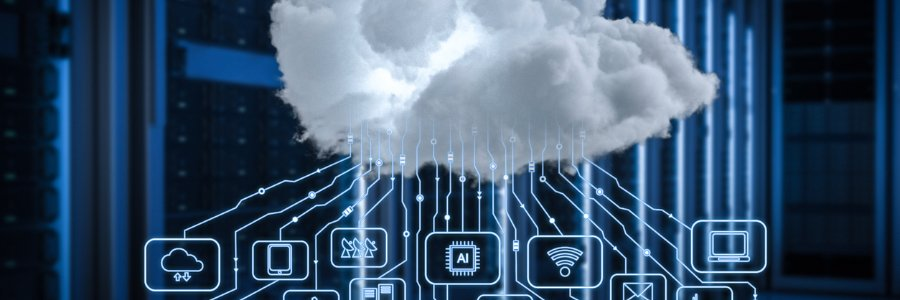

In [91]:
# 50, 15 , 55, 52, 22, 20
img_n = 50

img_list = list(pred_dict.keys())
test_image = img_list[img_n]
print(f' The predicted label is: {pred_dict[test_image]}')
Image.open(pred_path+"/"+test_image)



In [102]:
import random
import cv2 
from matplotlib import pyplot as plt



In [103]:
img_rand_imgs = random.choices(img_list,k=20)


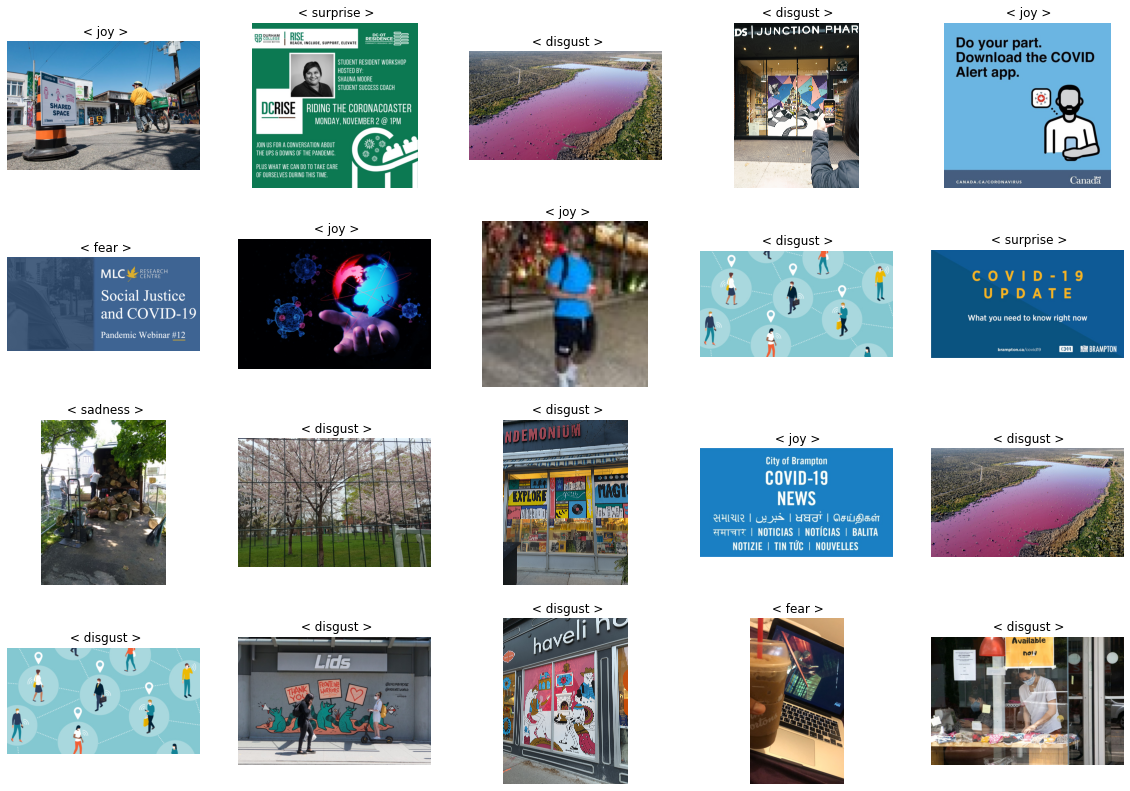

In [104]:
  
# create figure
fig = plt.figure(figsize=(20, 14))
  
# setting values to rows and column variables
rows = 4
columns = 5

i=1
for x in img_rand_imgs:
       img_path = pred_path + '/'+ x
       img = cv2.imread(img_path) 
       # Adds a subplot at the 1st position
       fig.add_subplot(rows, columns, i)
       
       
       # showing image
#        plt.imshow(img)
       plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        
    
       plt.axis('off')
       plt.title( f' < {pred_dict[x]} >' )
       i = i + 1
        

In [13]:
type(pred_dict)

dict

In [14]:
import pandas as pd

In [35]:
pd_img_results = pd.DataFrame([pred_dict])

In [50]:
#convert the dictionary into a dataframe

df = pd.DataFrame(list(pred_dict.items()),columns = ['filename','emotion']) 

grouped = df.groupby("emotion")

In [54]:
# count the number of occurrences
grouped.count()

,filename
emotion,
disgust,13
fear,5
joy,35
sadness,10
surprise,35
